In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def free_gpu_cache():
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
#free_gpu_cache()

In [3]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, tanh=False):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
        if tanh:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid()
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [4]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)

# 画ROC

In [9]:
path_LFI = './checkpoint1300008/30/'
path_Fea_G = './Fea_Gau/checkpoint1300000/60/'
path_Gaussian = './Gaussian/checkpoint1299999/800/'
path_Scheffe = './Scheffe/checkpoint1299999/50/'
path_Scheffe = './Scheffe/checkpoint1300100/120/'

path_dict_roc = {
    'MMD-L': path_LFI,
    'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}

100%|██████████| 4/4 [00:27<00:00,  6.77s/it]


ROC saved at ROC_curve.pdf


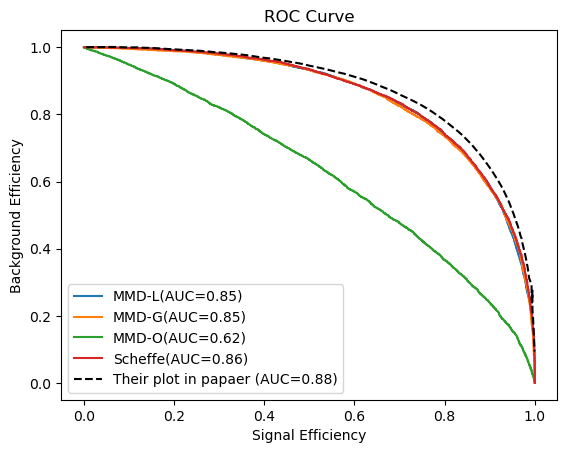

In [14]:
for key in tqdm(path_dict_roc):
    path = path_dict_roc[key]
    if key == 'Scheffe':
        model = Classifier(300, 6, True).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    gc.collect()
    torch.cuda.empty_cache()
    with torch.no_grad():
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, M=10000)
        PQhat = PQhat.cpu().detach().numpy()
        auc, x, y = get_auc_and_x_and_y(PQhat)
        label = key+'(AUC={:.2f})'.format(auc.item())
        plt.plot(x, y, label=label)
        p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
        print('p-value = %.3f'%p)
        clear_output(wait=True)
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')
plt.title('ROC Curve')
#plt.plot(0.8, 0.8, 'o', color='black')

df = pd.read_csv('Default Dataset.csv', header=None)
plt.plot(df[0], df[1], color='black', label='Their plot in papaer (AUC=0.88)', linestyle='--')
plt.legend()

plt.savefig('ROC_curve.pdf', dpi = 3000)
print('ROC saved at ROC_curve.pdf')


In [7]:
gc.collect()
torch.cuda.empty_cache()

# 画 p value - n

In [8]:
def get_ps(path_dict, method, fix_thres = 0.5, use_only_no_thres = False):
    print('-------- start get_ps --------')
    ps = np.zeros(len(path_dict))
    ps_thres = np.zeros(len(path_dict))
    ps_thres_5 = np.zeros(len(path_dict))
    for i, key in enumerate(path_dict):
        n = key
        path = path_dict[key]
        if method == 'Scheffe':
            model = Classifier(300, 6).cuda()
        if method == 'MMD-O':
            model = DN(300, 100).cuda()
        if method == 'MMD-L':
            model = DN(300, 100).cuda()
        if method == 'MMD-G':
            model = DN(300, 100).cuda()
        another_model = another_DN(300, 100).cuda()
        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
        gc.collect()
        torch.cuda.empty_cache()
        ##### 直接的pval，n_tr=n
        M = 10000
        # 选出来10000个P，10000个Q，应该是n_te
        X_test = dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)]
        Y_test = dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]
        Z = np.concatenate((X_test, Y_test), axis=0)
        Z = MatConvert(Z, device, dtype)
        # 算他的MMD distance
        # 包含了 n_ev=10000 的方差， 
        X_evaluate = dataset_P
        Y_evaluate = dataset_Q
        PQhat = compute_score_func(Z, X_evaluate, Y_evaluate, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 10000)
        PQhat = PQhat.cpu().detach().numpy()
        p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
        ps[i] = p
        if use_only_no_thres == True:
            continue
        #####################
        ##### 学thres, 还在training上学
        ##### 包含了 n_ev=1000 的方差，
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(n, min(n,M), replace=False)],
                    dataset_Q[np.random.choice(n, min(n,M), replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P[0:n], dataset_Q[0:n], 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 1000)
        PQhat = PQhat.cpu().detach().numpy()
        thres = get_thres(PQhat)
        ##### 用这个thres, z是n_te
        # 包含了 n_ev=10000 的方差，
        M = 10000 
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 10000)
        PQhat = PQhat.cpu().detach().numpy()
        p_thres = get_thres_pval(PQhat, thres)
        ps_thres[i] = p_thres
        ##### 用0.5
        p_thres_5 = get_thres_pval(PQhat, fix_thres)
        ps_thres_5[i] = p_thres_5
        #####
        print('n = %d'%key, ', p-value = %.3f'%p, 'p-value_thres = %.3f'%p_thres, 'thres = %.3f'%thres, 'p-value_thres_5 = %.3f'%p_thres_5)
        print('------------------------------')

    return ps, ps_thres, ps_thres_5

ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
ps_L = ps_G = ps_O = ps_S = np.zeros(ns.shape[0])

In [9]:
# MMD-L
path_dict = {    
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
}
ps_L, ps_L_thres, _ = get_ps(path_dict, 'MMD-L')
ps_L, ps_L_thres


-------- start get_ps --------
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
thres= 0.19806042 ,max= 0.24688804 ,min= -0.013262733
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
test max: 0.24423581 test min: -0.013669524
a: 0.2928 , b: 0.9784 , E: 50.87999999999995
test max: 0.24423581 test min: -0.013669524
a: 0.0 , b: 1.0 , E: 0.0
n = 1300000 , p-value = 4.472 p-value_thres = 4.860 thres = 0.198 p-value_thres_5 = inf
------------------------------
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
thres= 0.19171415 ,max= 0.24993668 ,min= -0.019935906
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
test max: 0.23365654 test min: -0.019709824
a: 0.2488 , b: 0.9856 , E: 39.279999999999966
test max: 0.23365654 test min: -0.019709824
a: 0.0 , b: 1.0 , E: 0.0
n = 1000000 , p-v

(array([4.47241689, 4.39115495, 4.41601965, 4.2411066 , 3.38121902,
        2.88668091]),
 array([4.85986256, 5.07294302, 4.04248415, 4.21594371, 2.52963913,
        2.59795433]))

In [10]:
# MMD-G
path_dict = {
    1300000: './Fea_Gau/checkpoint1300000/35/',
    1000000: './Fea_Gau/checkpoint1000000/35/',
    700000: './Fea_Gau/checkpoint700000/30/',
    400000: './Fea_Gau/checkpoint400000/30/',
    100000: './Fea_Gau/checkpoint100000/30/',
    50000: './Fea_Gau/checkpoint50000/30/',
}
ps_G, ps_G_thres, _ = get_ps(path_dict, 'MMD-G')
ps_G, ps_G_thres


-------- start get_ps --------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.21736911 ,max= 0.27646884 ,min= -0.016830474
epsilonOPT = Fea_Gau
It is Fea_Gau
test max: 0.28608033 test min: -0.013665205
a: 0.3434 , b: 0.9688 , E: 65.54
test max: 0.28608033 test min: -0.013665205
a: 0.0 , b: 1.0 , E: 0.0
n = 1300000 , p-value = 4.703 p-value_thres = 4.844 thres = 0.217 p-value_thres_5 = inf
------------------------------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.21771741 ,max= 0.28633055 ,min= -0.019471703
epsilonOPT = Fea_Gau
It is Fea_Gau
test max: 0.280141 test min: -0.01923344
a: 0.3132 , b: 0.9744 , E: 56.91999999999995
test max: 0.280141 test min: -0.01923344
a: 0.0 , b: 1.0 , E: 0.0
n = 1000000 , p-value = 4.575 p-value_thres = 4.797 thres = 0.218 p-value_thres_5 = inf
------------------------------
Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
epsilonOPT = Fea_Gau
It is Fea_Gau
thres= 0.22487009 ,ma

(array([4.70257259, 4.5747601 , 4.32984398, 4.24438148, 3.6229288 ,
        3.27990158]),
 array([4.8436075 , 4.79738356, 4.44104984, 4.3107332 , 3.06442633,
        2.95928844]))

In [11]:
# MMD-O
path_dict = {
    1300000: './Gaussian/checkpoint1299999/800/',
    1000000: './Gaussian/checkpoint1000000/430/',
    700000: './Gaussian/checkpoint700000/20/',
    400000: './Gaussian/checkpoint400000/10/',
    100000: './Gaussian/checkpoint100000/20/',
    50000: './Gaussian/checkpoint50000/40/',
}
ps_O, ps_O_thres, _ = get_ps(path_dict, 'MMD-O')
ps_O, ps_O_thres

-------- start get_ps --------
Gaussian
epsilonOPT = Gaussian
It is Gaussian
epsilonOPT = Gaussian
It is Gaussian
thres= 0.0027553556 ,max= 0.013413562 ,min= -0.007996997
epsilonOPT = Gaussian
It is Gaussian
test max: 0.011314863 test min: -0.0052559893
a: 0.5353 , b: 0.6342 , E: 419.33000000000004
test max: 0.011314863 test min: -0.0052559893
a: 0.0 , b: 1.0 , E: 0.0
n = 1300000 , p-value = 1.157 p-value_thres = 1.071 thres = 0.003 p-value_thres_5 = inf
------------------------------
Gaussian
epsilonOPT = Gaussian
It is Gaussian
epsilonOPT = Gaussian
It is Gaussian
thres= 4.3006145e-05 ,max= 0.0037106355 ,min= -0.003870701
epsilonOPT = Gaussian
It is Gaussian
test max: 0.0018944452 test min: -0.00096019683
a: 0.7839 , b: 0.4187 , E: 659.6899999999999
test max: 0.0018944452 test min: -0.00096019683
a: 0.0 , b: 1.0 , E: 0.0
n = 1000000 , p-value = 1.391 p-value_thres = 1.227 thres = 0.000 p-value_thres_5 = inf
------------------------------
Gaussian
epsilonOPT = Gaussian
It is Gaussian


(array([1.15665886, 1.39075333, 1.35354493, 1.29190365, 1.34813895,
        1.44878582]),
 array([1.07130992, 1.22748214, 1.12506925, 1.02313396, 1.12466228,
        0.91042114]))

In [12]:
# Scheffe
path_dict = {
    1300000: './Scheffe/checkpoint1299999/50/',
    1000000: './Scheffe/checkpoint1000000/30/',
    700000: './Scheffe/checkpoint700000/60/',
    400000: './Scheffe/checkpoint400000/60/',
    100000: './Scheffe/checkpoint100000/60/',
    50000: './Scheffe/checkpoint50000/60/',
}
ps_S, ps_S_thres, ps_S_thres_5 = get_ps(path_dict, 'Scheffe', fix_thres = 0.5)
ps_S, ps_S_thres, ps_S_thres_5

-------- start get_ps --------
Scheffe
epsilonOPT = Scheffe
It is Scheffe
epsilonOPT = Scheffe
It is Scheffe
thres= 0.91098434 ,max= 0.99958545 ,min= 1.6153332e-05
epsilonOPT = Scheffe
It is Scheffe
test max: 0.99945647 test min: 1.9562713e-06
a: 0.2311 , b: 0.9868 , E: 36.30999999999999
test max: 0.99945647 test min: 1.9562713e-06
a: 0.7755 , b: 0.7615 , E: 316.05000000000007
n = 1300000 , p-value = 4.651 p-value_thres = 4.912 thres = 0.911 p-value_thres_5 = 3.755
------------------------------
Scheffe
epsilonOPT = Scheffe
It is Scheffe
epsilonOPT = Scheffe
It is Scheffe
thres= 0.8980668 ,max= 0.9968454 ,min= 3.1003324e-06
epsilonOPT = Scheffe
It is Scheffe
test max: 0.9977113 test min: 0.00014770009
a: 0.2337 , b: 0.9872 , E: 36.17000000000003
test max: 0.9977113 test min: 0.00014770009
a: 0.7654 , b: 0.7445 , E: 332.03999999999996
n = 1000000 , p-value = 4.470 p-value_thres = 5.053 thres = 0.898 p-value_thres_5 = 3.497
------------------------------
Scheffe
epsilonOPT = Scheffe
It i

(array([4.65106616, 4.47029426, 4.32129419, 4.13171039, 3.48099318,
        3.12310469]),
 array([4.91222778, 5.0525029 , 4.9904022 , 4.49261353, 3.48895204,
        2.91884383]),
 array([3.75502734, 3.49720095, 3.4419775 , 3.38683509, 2.76909273,
        2.5010312 ]))

In [13]:
cc = (1/11*np.sqrt(1100)) / (1/10.5*np.sqrt(1050))
cc

0.9770084209183946

p-n saved at p_n_curve.pdf


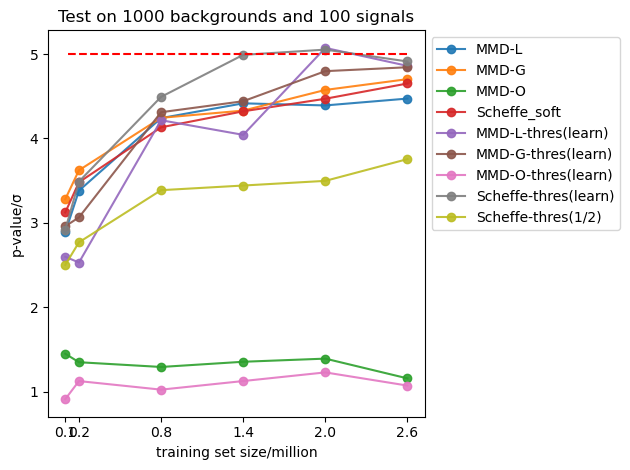

In [14]:
# for ps in [ps_L, ps_G, ps_O, ps_S]:
#     ps = ps /(1/11*np.sqrt(1100)) * (1/10.5*np.sqrt(1050))
ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
# 直接求和
plt.plot(ns, ps_L, label='MMD-L', marker='o', alpha=0.9)
plt.plot(ns, ps_G, label='MMD-G', marker='o', alpha=0.9)
plt.plot(ns, ps_O, label='MMD-O', marker='o', alpha=0.9)
plt.plot(ns, ps_S, label='Scheffe_soft', marker='o', alpha=0.9)
# 加上threshold
plt.plot(ns, ps_L_thres, label='MMD-L-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_G_thres, label='MMD-G-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_O_thres, label='MMD-O-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_S_thres, label='Scheffe-thres(learn)', marker='o', alpha=0.9)
plt.plot(ns, ps_S_thres_5, label='Scheffe-thres(1/2)', marker='o', alpha=0.9)


plt.legend(bbox_to_anchor =(1, 1))
plt.xlabel('training set size/million')
plt.xticks(ns, ns*2/10**6)
plt.ylabel('p-value/σ')
plt.title('Test on 1000 backgrounds and 100 signals')
plt.tight_layout()

#plt.yticks([cc, 2*cc, 3*cc, 4*cc, 5*cc, 5], [1, 2, 3, 4 ,5, '5σ'])
plt.plot(ns, 5*np.ones(ns.shape[0]), 'r--')

#plt.savefig('p_n_curve.pdf')
plt.savefig('p_n_curve.png')
print('p-n saved at p_n_curve.pdf')
plt.show()



# 画training of LFI

In [15]:
# gc.collect()
# torch.cuda.empty_cache()
# model = DN(300, 100).to(device)
# another_model = another_DN(300).to(device)

# epoch_list = np.arange(0,176,10)

# p_epoch = np.zeros(epoch_list.shape[0])
# p_thres_epoch = np.zeros(epoch_list.shape[0])
# pat = './checkpoint999999/'
# J_epoch = np.load(pat+'J_star_u.npy')
# J_valid_epoch = np.load(pat+'J_validations.npy')
# mmd_epoch = np.load(pat+'mmd_val_record.npy')

# for i, epoch in tqdm(enumerate(epoch_list)):
#     path = './checkpoint999999/%d/'%epoch
#     model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
#     M = 10000
#     Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
#         dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
#     Z = MatConvert(Z, device, dtype)
#     PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
#                 model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
#                 M = 10000)
#     PQhat = PQhat.cpu().detach().numpy()
#     p_epoch[i] = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
#     p_thres_epoch[i] = get_thres_pval(PQhat)
#     clear_output(wait = True)
#     print(p_epoch[i], p_thres_epoch[i])


In [16]:

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(epoch_list, J_epoch[0,epoch_list], label='J', marker='o', alpha=0.9, color='r')
# ax.plot(epoch_list, J_valid_epoch[epoch_list], label='J_valid', marker='o', alpha=0.9, color='g')
# ax.plot(epoch_list, mmd_epoch[0,epoch_list], label='mmd', marker='o', alpha=0.9, color='y')
# ax.set_ylabel("Loss")
# ax2 = ax.twinx()
# ax2.set_ylabel("p-value")
# ax2.plot(epoch_list, p_epoch, label='p-value', marker='o', alpha=0.9, color='k')
# ax2.plot(epoch_list, p_thres_epoch, label='p-thres', marker='o', alpha=0.9, color='b')
# fig.legend(loc=1, bbox_to_anchor=(1.16,0.9))
# ax.set_xlabel('epoch')
# plt.savefig('loss_p_epoch.pdf')

# 画J-n

In [17]:
path_dict_J = {    
    1300000: './checkpoint1300101/',
    1000000: './checkpoint1000101/',
    700000: './checkpoint700101/',
    400000: './checkpoint400101/',
    100000: './checkpoint100101/',
    50000: './checkpoint50101/',
}

# 画 

# Trade-off of m-n-pi, fix pi=0.1
# Gaussian 和 Binomial
# 在n训一个kernel，还在前n找thrers，
# 然后在全部dataset随机n个，算a,b

In [19]:
# 希望横轴是n，纵轴是m，固定3sigma，画pi的等高线
c = 11/np.sqrt(1100)
# 如果高斯近似，一个n上所有点都能算，对一个model我们需要P_mean, P_var, Q_mean
def get_gaussian_pval(n,m,pi,method=None, thres=False):
    i = np.where(ns==n)
    if method == 'MMD-L':
        return ps_L[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-G':
        return ps_G[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-O':
        return ps_O[i]*c*pi*np.sqrt(m)
    elif method == 'Scheffe':
        return ps_S[i]*c*pi*np.sqrt(m)
# MMD-L
path_dict_more = {    
    1600000: './checkpoint1600101/30/',
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
    10000: './checkpoint10000/170/',
    6000: './checkpoint6000/330/',
    3000: './checkpoint3000/400/',  
    1000: './checkpoint1000/70/',
    600: './checkpoint600/200/',
    300: './checkpoint300/300/'
}

# 高斯

In [20]:
# 用高斯
ps_L_more, ps_L_thres_more, _ = get_ps(path_dict_more, 'MMD-L', use_only_no_thres=True)

-------- start get_ps --------
epsilonOPT = tensor([-1.3945], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-2.5230], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-2.7914], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([0.7965], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-0.0785], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-0.2973], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([-1.6631], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([0.2923], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([0.5609], device='cuda:0', requires_grad=True)
epsilonOPT = tensor([2.5756], device='cuda:0', requires_grad=True)


In [21]:
ns = np.array(list(path_dict_more.keys()))
ms = np.array([10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000, 60000])
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    for j,m in enumerate(ms):
        pi = 5/ps_L_more[i]/c/np.sqrt(m)
        Znm[i,j] = pi
        dict = {'n':n, 
                'm':m, 
                'pi':pi.item(), 
                'p-value': 5}
        df = df.append(dict, ignore_index=True)
        clear_output(wait = True)

/tmp/ipykernel_18139/2272938270.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict, ignore_index=True)


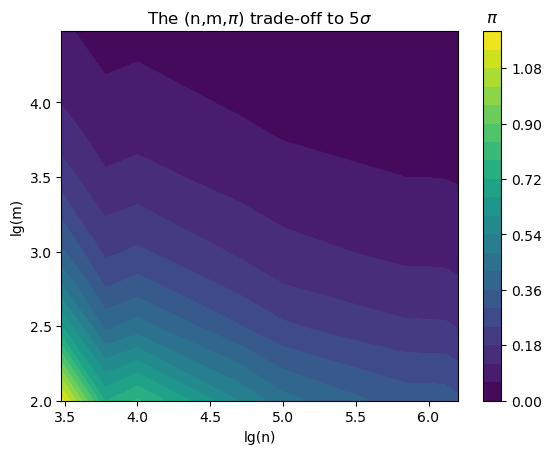

In [22]:
plt.contourf(np.log10(ns[0:-3]), np.log10(ms[3:-1]), Znm[0:-3,3:-1].T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')
# plt.xlim(np.log10(6000), np.log10(1600000))
# plt.ylim(1,4)
#plt.plot([4,6],[3,2], 'r--', label = 'slope=-1')
#plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off_gau.png')

# Binomial

In [23]:
# 硬算 thres
ns = np.array(list(path_dict_more.keys()))
ns = ns[0:len(ns)-3]
ms = np.array([10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000, 60000])
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    ##### 先找threshold 

    model = DN(300, 100).cuda()
    another_model = another_DN(300, 100).cuda()
    path = path_dict_more[n]
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    M = 10000
    Z = np.concatenate((dataset_P[np.random.choice(n, min(n,M), replace=False)],
                dataset_Q[np.random.choice(n, min(n,M), replace=False)]), axis=0)
    Z = MatConvert(Z, device, dtype)
    PQhat = compute_score_func(Z, dataset_P[0:n], dataset_Q[0:n], 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = min(n,M))
    PQhat = PQhat.cpu().detach().numpy()
    thres = get_thres(PQhat)
    ##### 再找 a,b
    ##### a,b已经考虑到n个的随机性吗？
    ##### 也就是算PQhat set M=n
    ##### 反复取Z
    M = 10000
    Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], min(n,M), replace=False)],
                dataset_Q[np.random.choice(dataset_Q.shape[0],min(n,M), replace=False)]), axis=0)
    Z = MatConvert(Z, device, dtype)
    PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = min(n,M))
    PQhat = PQhat.cpu().detach().numpy()
    print('n:', n)
    a = np.mean(PQhat[M:]>thres).item() # sig->sig
    b = np.mean(PQhat[:M]<thres).item() # bkg->bkg
    print('n: ', n, ', a:', a, ', b:', b)
    print('-----------------------------')
    for j,m in enumerate(ms):
        ##### 求pi达到5sig
        E = scipy.stats.binom.ppf(scipy.stats.norm.cdf(5), m, 1-b) # E = m*(pi*a+(1-pi)*(1-b))
        pi = (E/m+b-1)/(a+b) # 5sig
        Znm[i,j] = pi##
        # dict = {'n':n, 
        #         'm':m, 
        #         'pi':pi, 
        #         'p-value': 5}
        # df = df.append(dict, ignore_index=True)
        #clear_output(wait = True)
# fig = px.scatter_3d(df, x='n', y='m', z='pi')
# fig.show()

epsilonOPT = tensor([-1.3945], device='cuda:0', requires_grad=True)
thres= 0.19764605 ,max= 0.25184825 ,min= -0.010065904
epsilonOPT = tensor([-1.3945], device='cuda:0', requires_grad=True)
n: 1600000
n:  1600000 , a: 0.2842 , b: 0.9814
-----------------------------
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
thres= 0.19913639 ,max= 0.24878138 ,min= -0.01562535
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
n: 1300000
n:  1300000 , a: 0.3214 , b: 0.9752
-----------------------------
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
thres= 0.18396169 ,max= 0.23968047 ,min= -0.018888772
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
n: 1000000
n:  1000000 , a: 0.2953 , b: 0.9766
-----------------------------
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
thres= 0.17312229 ,max= 0.22686186 ,min= -0.01851077
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
n: 700000
n

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


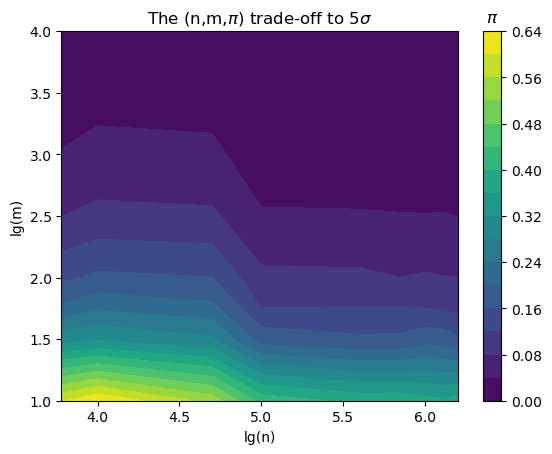

In [24]:
plt.contourf(np.log10(ns), np.log10(ms), Znm.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')
plt.xlim(np.log10(6000), np.log10(1600000))
plt.ylim(1,4)
#plt.plot([4,6],[3,2], 'r--', label = 'slope=-1')
#plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off.png')

# Trade-off 但定kernel, 不thres

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(0.5, 1.0, 'The (n,m,$\\pi$) trade-off to 5$\\sigma$')

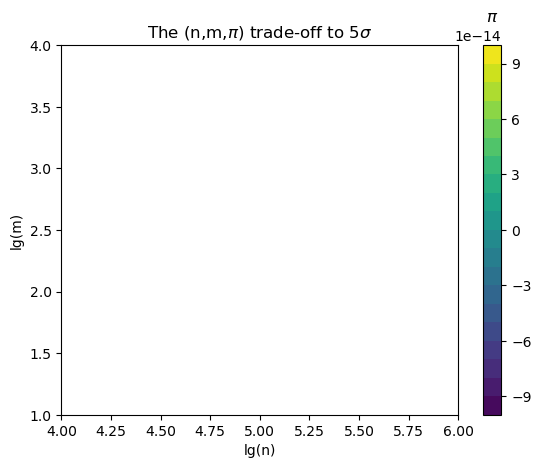

In [25]:
ns_fix_ker = np.logspace(4, 6, 10)
ms_fix_ker = np.logspace(1, 4, 10)
Znm_another = np.zeros((len(ns_fix_ker), len(ms_fix_ker)))
for i,n in enumerate(ns_fix_ker):
    for j,m in enumerate(ms_fix_ker):
        ##### 求pi达到5sig
        E = scipy.stats.binom.ppf(scipy.stats.norm.cdf(5), m, 1-b) # E = m*(pi*a+(1-pi)*(1-b))
        pi = (E/m+b-1)/(a+b) # 5sig
        Znm_another[i,j] = pi##
plt.contourf(np.log10(ns_fix_ker), np.log10(ms_fix_ker), Znm_another.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$')